In [2]:
__depends__ = [
    "../outputs/online_budget_runs_df.h5",
    "utils_config.py",
    "utils_latex.py",
]
__dest__ = [
    "../figures/online_budget_runs_overview.pdf",
]

Cell above is scons stuff to make sure our dependency tree work. We put a renaming in the cell below to make it clearer what is what.

In [3]:
ONLINE_BUDGET_RUNS_DF_H5 = __depends__[0]

ONLINE_RUNS_OVERVIEW_FIGURE = __dest__[0]

In [4]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Online simulations visualisation

## Imports

In [5]:
import numpy as np
import pandas as pd
import pyam
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tqdm

from utils_openscm import load_scmdataframe, load_df, ScmDataFrame

<IPython.core.display.Javascript object>

`formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


<IPython.core.display.Javascript object>

## Plotting config

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

from utils_plotting import (
    COLOURS,
    SCATTER_UNDER_LINE_ALPHA,
    SAVE_KWARGS,
    setup,
    get_annotation_for_panel_number,
)

setup()

<IPython.core.display.Javascript object>

## Constants

In [7]:
SR1_5_HIST_WARMING = 0.97
HAWKINS_2017_WARMING_1750_1850 = 0.05
TOTAL_HIST_WARMING = SR1_5_HIST_WARMING + HAWKINS_2017_WARMING_1750_1850

<IPython.core.display.Javascript object>

## Load data

In [8]:
db = load_df(ONLINE_BUDGET_RUNS_DF_H5)
db.head()

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


model                scenario region                        variable  \
241  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Atmospheric Concentrations|CO2   
242  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Atmospheric Concentrations|CO2   
243  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Atmospheric Concentrations|CO2   
244  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Atmospheric Concentrations|CO2   
245  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Atmospheric Concentrations|CO2   

    unit       time  core_feedback_qsensitivity  core_delq2xco2  \
241  ppm 2006-01-01                     -9999.0         -9999.0   
242  ppm 2007-01-01                     -9999.0         -9999.0   
243  ppm 2008-01-01                     -9999.0         -9999.0   
244  ppm 2009-01-01                     -9999.0         -9999.0   
245  ppm 2010-01-01                     -9999.0         -9999.0   

    rf_total_runmodus  co2_feedbackfactor_soil  ...  co2_tempfeedback_switch  \
241               all                 0.154088  ...                  -9999.0   
242               all                 0.154088  ...                  -9999.0   
243               all                 0.154088  ...                  -9999.0   
244               all                 0.154088  ...                  -9999.0   
245               all                 0.154088  ...                  -9999.0   

     co2_switchfromconc2emis_year  co2_feedbackfactor_detritus  \
241                          1750                    -0.135782   
242                          1750                    -0.135782   
243                          1750                    -0.135782   
244                          1750                    -0.135782   
245                          1750                    -0.135782   

    co2_soilpool_initial  core_verticaldiff_top_dkdt  \
241             1681.525                     -9999.0   
242             1681.525                     -9999.0   
243             1681.525                     -9999.0   
244             1681.525                     -9999.0   
245             1681.525                     -9999.0   

     core_amplify_ocn2land_heatxchng pf_apply  rf_total_constantafteryr  \
241                          -9999.0      1.0                   -9999.0   
242                          -9999.0      1.0                   -9999.0   
243                          -9999.0      1.0                   -9999.0   
244                          -9999.0      1.0                   -9999.0   
245                          -9999.0      1.0                   -9999.0   

     out_permafrost      value  
241             1.0  368.85294  
242             1.0  371.00453  
243             1.0  373.18794  
244             1.0  375.40584  
245             1.0  377.64658  

[5 rows x 58 columns]

<IPython.core.display.Javascript object>

In [9]:
db["carbon_cycle_tuning"].unique()

array(['default'], dtype=object)

<IPython.core.display.Javascript object>

In [10]:
db["ocean_tuning"].unique()

array(['N/A'], dtype=object)

<IPython.core.display.Javascript object>

In [11]:
tmp = db.copy()
tmp["year"] = tmp["time"].apply(lambda x: x.year)
tmp = tmp.drop("time", axis="columns")
iamdf = pyam.IamDataFrame(tmp)
iamdf.head()

model                scenario region                        variable  \
0  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Atmospheric Concentrations|CO2   
1  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Atmospheric Concentrations|CO2   
2  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Atmospheric Concentrations|CO2   
3  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Atmospheric Concentrations|CO2   
4  AIM_2_0  ADVANCE_2020_1.5C-2100  World  Atmospheric Concentrations|CO2   

  unit  year  co2_feedbackfactor_gpp  core_feedback_qsensitivity  \
0  ppm  2006                  0.0107                     -9999.0   
1  ppm  2007                  0.0107                     -9999.0   
2  ppm  2008                  0.0107                     -9999.0   
3  ppm  2009                  0.0107                     -9999.0   
4  ppm  2010                  0.0107                     -9999.0   

   co2_soilpool_initial  core_verticaldiffusivity  ...  endyear  \
0              1681.525                   -9999.0  ...     2110   
1              1681.525                   -9999.0  ...     2110   
2              1681.525                   -9999.0  ...     2110   
3              1681.525                   -9999.0  ...     2110   
4              1681.525                   -9999.0  ...     2110   

  co2_tempfeedback_switch  co2_fertilization_yrstart  \
0                 -9999.0                       1750   
1                 -9999.0                       1750   
2                 -9999.0                       1750   
3                 -9999.0                       1750   
4                 -9999.0                       1750   

   core_hemisfraction_nh_land  co2_gpp_initial  co2_tempfeedback_yrstart  \
0                     -9999.0          66.2716                      1750   
1                     -9999.0          66.2716                      1750   
2                     -9999.0          66.2716                      1750   
3                     -9999.0          66.2716                      1750   
4                     -9999.0          66.2716                      1750   

   todo  co2_feedbackfactor_detritus  co2_fertilization_method      value  
0   N/A                    -0.135782                  1.100486  368.85294  
1   N/A                    -0.135782                  1.100486  371.00453  
2   N/A                    -0.135782                  1.100486  373.18794  
3   N/A                    -0.135782                  1.100486  375.40584  
4   N/A                    -0.135782                  1.100486  377.64658  

[5 rows x 58 columns]

<IPython.core.display.Javascript object>

In [12]:
iamdf.variables(True)

variable         unit
0                      Atmospheric Concentrations|CO2          ppm
1                            Cumulative Emissions|CO2       Gt CO2
2             Cumulative Emissions|CO2 (rel. to 2011)       Gt CO2
3   Cumulative Land to Air Flux|CO2|MAGICC Permafrost       Gt CO2
4                                       Emissions|CO2  Gt CO2 / yr
5                          Emissions|CO2|MAGICC AFOLU  Gt CO2 / yr
6          Emissions|CO2|MAGICC Fossil and Industrial  Gt CO2 / yr
7              Land to Air Flux|CO2|MAGICC Permafrost  Gt CO2 / yr
8                                   Radiative Forcing      W / m^2
9                          Radiative Forcing|Aerosols      W / m^2
10           Radiative Forcing|Aerosols|Direct Effect      W / m^2
11         Radiative Forcing|Aerosols|Indirect Effect      W / m^2
12                              Radiative Forcing|CO2      W / m^2
13                 Radiative Forcing|Greenhouse Gases      W / m^2
14                      Radiative Forcing|Non-CO2 GHG      W / m^2
15                                Surface Temperature            K
16            Surface Temperature (rel. to 2006-2015)            K

<IPython.core.display.Javascript object>

In [13]:
iamdf_subset = iamdf.filter(
    variable=[
        "Cumulative Emissions|CO2 (rel. to 2011)",
        "Atmospheric Concentrations|CO2",
        "Radiative Forcing",
        "Radiative Forcing|Aerosols",
        "Radiative Forcing|Non-CO2 GHG",
        "Surface Temperature (rel. to 2006-2015)",
    ]
)

<IPython.core.display.Javascript object>

In [14]:
for col in db:
    if "carbon_budget_temperature" in col:
        carbon_budget_surf_temp_col = col
        print(carbon_budget_surf_temp_col)
    if "carbon_budget_emissions" in col:
        carbon_budget_cumulative_emms_col = col
        print(carbon_budget_cumulative_emms_col)

carbon_budget_emissions_from_2011__gt_co2_
carbon_budget_temperature__rel__to_2006_2015_


<IPython.core.display.Javascript object>

Make new Figure 2, which has timeseries of variables of interest (cumulative CO2 emms, CO2 conc, non-CO2 and aerosol RF, \Delta T) from integrated simulations (caption will have to explain why we don’t always use peak cumulative CO2 emissions)

In [15]:
tmp = iamdf_subset.data
scatter_data = {
    "cb_temperature": [],
    "cb_temperature_year": [],
    "cb_cumulative_emissions": [],
    "cb_cumulative_emissions_year": [],
}
for (model, scenario), sdf in tqdm.tqdm_notebook(tmp.groupby(["model", "scenario"])):
    cb_temperature = sdf[carbon_budget_surf_temp_col].unique()
    assert len(cb_temperature) == 1
    cb_temperature = cb_temperature[0]
    temperatures = sdf[sdf["variable"] == "Surface Temperature (rel. to 2006-2015)"][
        "value"
    ]
    match_idx_temperature = np.abs(temperatures - cb_temperature).idxmin()
    match_year_temperature = sdf.loc[match_idx_temperature]["year"]
    if match_year_temperature >= 2099:
        continue

    cb_cumulative_emissions = sdf[carbon_budget_cumulative_emms_col].unique()
    assert len(cb_cumulative_emissions) == 1
    cb_cumulative_emissions = cb_cumulative_emissions[0]
    cumulative_emissions = sdf[
        sdf["variable"] == "Cumulative Emissions|CO2 (rel. to 2011)"
    ]["value"]
    match_idx_cumulative_emissions = np.abs(
        cumulative_emissions - cb_cumulative_emissions
    ).idxmin()
    match_year_cumulative_emissions = sdf.loc[match_idx_cumulative_emissions]["year"]
    if match_year_cumulative_emissions >= 2099:
        continue

    scatter_data["cb_temperature"].append(cb_temperature)
    scatter_data["cb_temperature_year"].append(match_year_temperature)
    scatter_data["cb_cumulative_emissions"].append(cb_cumulative_emissions)
    scatter_data["cb_cumulative_emissions_year"].append(match_year_cumulative_emissions)

scatter_data = pd.DataFrame(scatter_data)
scatter_data.head()

cb_temperature  cb_temperature_year  cb_cumulative_emissions  \
0        0.632057                 2042               820.594133   
1        0.687737                 2054              1035.760367   
2        0.843157                 2045              1048.328967   
3        0.890632                 2049              1165.423673   
4        0.626443                 2042               834.354583   

   cb_cumulative_emissions_year  
0                          2045  
1                          2088  
2                          2051  
3                          2054  
4                          2055

<IPython.core.display.Javascript object>

In [16]:
def get_nonco2_fit(idf):
    nonco2_fit_df = idf[[peak_surf_temp_col, "Surface Temperature non-CO2"]].astype(
        float
    )
    nonco2_fit_df = make_column_names_smf_safe(nonco2_fit_df)

    fit_results = smf.ols(
        "Surface_Temperature_non_CO2 ~ peak_surface_temperature_rel_to_ref_period",
        data=nonco2_fit_df,
    ).fit()

    return fit_results

<IPython.core.display.Javascript object>

                            OLS Regression Results                            
Dep. Variable:         cb_temperature   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     931.5
Date:                Wed, 18 Mar 2020   Prob (F-statistic):           3.57e-75
Time:                        13:20:56   Log-Likelihood:                 234.73
No. Observations:                 192   AIC:                            -465.5
Df Residuals:                     190   BIC:                            -458.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

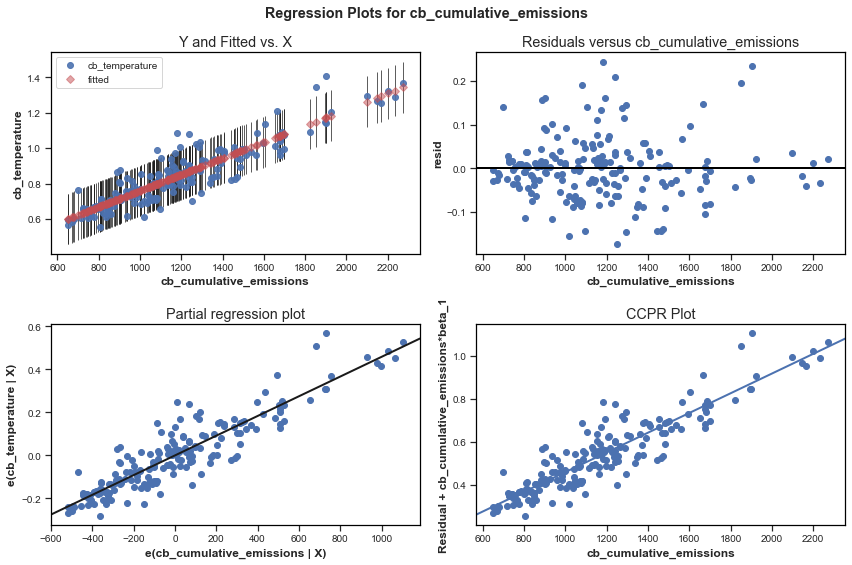

<IPython.core.display.Javascript object>

In [17]:
fit_results = smf.ols(
    "cb_temperature ~ cb_cumulative_emissions", data=scatter_data
).fit()

grad = fit_results.params["cb_cumulative_emissions"]
intercept = fit_results.params["Intercept"]

print(fit_results.summary())
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_regress_exog(fit_results, "cb_cumulative_emissions", fig=fig)

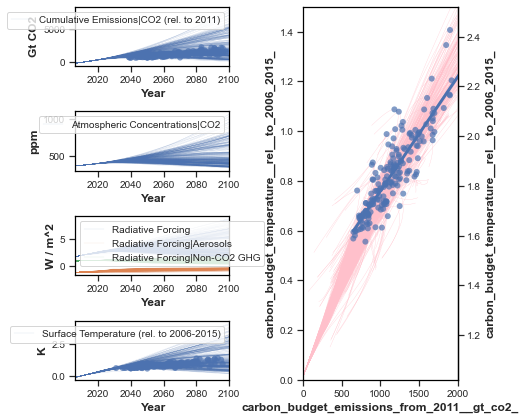

<IPython.core.display.Javascript object>

In [20]:
import warnings

warnings.filterwarnings("ignore")  # shush matplotlib deprecation warning

fig = plt.figure()
axes = [
    fig.add_subplot(421),
    fig.add_subplot(423),
    fig.add_subplot(425),
    fig.add_subplot(427),
    fig.add_subplot(122),
]

scatter_kwargs = {"alpha": 0.7, "edgecolor": "", "zorder": 4}


def plot_var_here(idf, var, ax):
    pdf = idf.filter(variable=var)
    pdf.line_plot(color="variable", linewidth=0.25, alpha=0.3, ax=ax)
    unit = pdf["unit"].unique()
    assert len(unit) == 1, unit
    unit = unit[0]
    ylabel = "{}".format(unit)
    ax.set_ylabel(ylabel)
    ax.set_title("")


plot_var_here(iamdf_subset, "Cumulative Emissions|CO2 (rel. to 2011)", axes[0])
axes[0].scatter(
    scatter_data["cb_cumulative_emissions_year"],
    scatter_data["cb_cumulative_emissions"],
    **scatter_kwargs
)
plot_var_here(iamdf_subset, "Atmospheric Concentrations|CO2", axes[1])
plot_var_here(
    iamdf_subset,
    [
        "Radiative Forcing",
        "Radiative Forcing|Aerosols",
        "Radiative Forcing|Non-CO2 GHG",
    ],
    axes[2],
)
plot_var_here(iamdf_subset, "Surface Temperature (rel. to 2006-2015)", axes[3])
axes[3].scatter(
    scatter_data["cb_temperature_year"],
    scatter_data["cb_temperature"],
    **scatter_kwargs
)

budget_df = iamdf_subset.pivot_table(
    columns=["variable"], index=["year", "model", "scenario"], aggfunc="sum"
)

for (model, scenario), df in tqdm.tqdm_notebook(
    budget_df.groupby(["model", "scenario"])
):
    axes[4].plot(
        df["Cumulative Emissions|CO2 (rel. to 2011)"],
        df["Surface Temperature (rel. to 2006-2015)"],
        linewidth=0.25,
        color="pink",
        zorder=1.1,
    )

axes[4].scatter(
    scatter_data["cb_cumulative_emissions"],
    scatter_data["cb_temperature"],
    **scatter_kwargs
)
xrange = np.array(
    [
        scatter_data["cb_cumulative_emissions"].min(),
        scatter_data["cb_cumulative_emissions"].max(),
    ]
)
axes[4].plot(xrange, xrange * grad + intercept, linewidth=3)

axes[4].set_xlim([0, 2000])
axes[4].set_ylim([0, 1.5])
axes[4].set_xlabel(carbon_budget_cumulative_emms_col)
axes[4].set_ylabel(carbon_budget_surf_temp_col)


def pd_to_hist(x):
    return x + TOTAL_HIST_WARMING


def hist_to_pd(x):
    return x - TOTAL_HIST_WARMING


secaxy = axes[4].secondary_yaxis("right", functions=(pd_to_hist, hist_to_pd))
secaxy.set_ylabel(
    carbon_budget_surf_temp_col.replace("rel. to 2006-2015", "rel. to 1720-1800")
)


plt.tight_layout()
fig.savefig(ONLINE_RUNS_OVERVIEW_FIGURE, **SAVE_KWARGS)